In [87]:
import json
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind 
from scipy.stats import anderson, anderson_ksamp
from scipy.stats import chi2, t, sem
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import random
import warnings
warnings.filterwarnings('ignore')
from dataclasses import asdict
from datetime import datetime, date
import io

all_data = pd.read_csv('/kaggle/input/shiftlogs/application_train.csv')

In [88]:
house_columns = ['NAME_HOUSING_TYPE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
                 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                 'YEARS_BUILD_MODE' ,'COMMONAREA_MODE' , 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE' ,'APARTMENTS_MEDI',
                 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
                 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [89]:
application_train_test = pd.DataFrame()

application_train_test['SK_ID_CURR'] = all_data['SK_ID_CURR']

application_train_test['TARGET'] = all_data['TARGET']

application_train_test['Кол-во документов'] = all_data.loc[:, 'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].sum(axis=1)

application_train_test['Информация о доме'] = np.where(all_data.loc[:, house_columns].isnull().sum(axis=1) < 30, 1, 0)

application_train_test['Кол-во полных лет'] = abs(all_data['DAYS_BIRTH']/365).apply(np.int64)

application_train_test['Год смены документа'] = application_train_test['Кол-во полных лет'] - abs(all_data['DAYS_REGISTRATION']/365).apply(np.int64)

# application_train_test['Разница во времени между сменой документа и возрастом на момент смены документы'] = вообще не понял вопроса =)

application_train_test['Признак задержки смены документа'] = np.where(application_train_test['Год смены документа'] != 14|20|45, 1, 0)

application_train_test['Доля денег которые клиент отдает на займ за год'] = all_data['AMT_ANNUITY']/all_data['AMT_INCOME_TOTAL']

application_train_test['Среднее кол-во детей в семье на одного взрослого'] = all_data['CNT_CHILDREN'] / (all_data['CNT_FAM_MEMBERS'] - all_data['CNT_CHILDREN']) 

application_train_test['Средний доход на ребенка'] = all_data['AMT_INCOME_TOTAL'] / all_data['CNT_CHILDREN']

application_train_test['Средний доход на взрослого'] = all_data['AMT_INCOME_TOTAL'] / (all_data['CNT_FAM_MEMBERS'] - all_data['CNT_CHILDREN'])

application_train_test['Процентная ставка'] = ((all_data['AMT_CREDIT'] - all_data['AMT_GOODS_PRICE']) / ((all_data['AMT_CREDIT'] / all_data['AMT_ANNUITY']) / 12)) / all_data['AMT_GOODS_PRICE']

application_train_test[['скор внеешних источников1', 'скор внеешних источников2', 'скор внеешних источников3']] = all_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

In [90]:
# экономим время, обрезаем датасет
application_train_test = application_train_test.dropna() 
application_train_test = application_train_test.sample(10_000)
application_train_test.replace([np.inf, -np.inf], 0, inplace=True) # заменяем inf на 0
application_train_test

,SK_ID_CURR,TARGET,Кол-во документов,Информация о доме,Кол-во полных лет,Год смены документа,Признак задержки смены документа,Доля денег которые клиент отдает на займ за год,Среднее кол-во детей в семье на одного взрослого,Средний доход на ребенка,Средний доход на взрослого,Процентная ставка,скор внеешних источников1,скор внеешних источников2,скор внеешних источников3
139822,262134,0,1,0,56,25,1,0.297133,0.0,0.0,202500.0,0.065478,0.718949,0.695224,0.622922
81613,194640,0,1,1,53,45,1,0.065686,0.0,0.0,157500.0,0.115241,0.760307,0.708153,0.429424
223097,358404,0,1,1,41,16,1,0.193750,1.0,135000.0,135000.0,0.065500,0.719582,0.767331,0.562060
293171,439643,0,1,0,49,32,1,0.119909,0.5,297000.0,148500.0,0.063026,0.477837,0.674395,0.324891
77865,190269,0,1,0,29,25,1,0.110175,1.0,256500.0,256500.0,0.137790,0.115494,0.426714,0.466864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302872,450900,0,1,0,54,34,1,0.193600,0.0,0.0,56250.0,0.000000,0.650634,0.544814,0.130947
62607,172610,0,1,0,37,25,1,0.185700,0.0,0.0,45000.0,0.103940,0.267013,0.590139,0.706205
143087,265908,0,1,0,23,15,1,0.468933,0.5,67500.0,33750.0,0.069753,0.411729,0.307697,0.178760
39128,145314,1,1,0,26,15,1,0.079180,0.0,0.0,225000.0,0.216542,0.109839,0.440133,0.225087


Как и в предыдущей домашке, вам требуется обучить модели. Теперь следует попробовать использовать алгоритмы "случайный лес" и "градиентный бустинг". Затем на обученных в обеих домашках моделях нужно реализовать блендинг и стейкинг и сравнить результаты, полученные при обучении моделей с помощью разных алгоритмов 

In [91]:
X = application_train_test.drop('TARGET', axis=1)
y = application_train_test['TARGET']

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import tree

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [94]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [95]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=27)
bagging_clf = BaggingClassifier(base_estimator=tree_clf, n_estimators=100, random_state=0)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=27),
                  n_estimators=100, random_state=0)

In [96]:
print(f'train: {roc_auc_score(y_train, bagging_clf.predict_proba(X_train)[:, 1])}', 
      f'test: {roc_auc_score(y_test, bagging_clf.predict_proba(X_test)[:, 1])}')

train: 0.7294305177510341 test: 0.7312536929903475


In [97]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=27)
bagging_clf = BaggingClassifier(base_estimator=tree_clf, n_estimators=100, random_state=0, 
                                max_features=0.7)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        random_state=27),
                  max_features=0.7, n_estimators=100, random_state=0)

In [98]:
print(f'train: {roc_auc_score(y_train, bagging_clf.predict_proba(X_train)[:, 1])}', 
      f'test: {roc_auc_score(y_test, bagging_clf.predict_proba(X_test)[:, 1])}')

train: 0.740964333298317 test: 0.7456154901687303


In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
rf_clf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=27, max_features=0.7)
rf_clf.fit(X_train, y_train)
print(f'train: {roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:, 1])}', 
      f'test: {roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])}')

train: 0.7340542955061327 test: 0.7364243376878435


In [101]:
rf_clf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=27)
rf_clf.fit(X_train, y_train)
print(f'train: {roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:, 1])}', 
      f'test: {roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])}')

train: 0.738648436095223 test: 0.7443648293631575


In [102]:
rf_clf.feature_importances_

array([1.91404670e-03, 1.57554959e-02, 1.28511197e-02, 3.56118776e-02,
       7.60435130e-03, 1.58955850e-04, 1.20347622e-02, 3.13557298e-04,
       1.24489203e-03, 9.42573084e-04, 5.33683746e-02, 2.97426362e-01,
       2.08768302e-01, 3.52005330e-01])

In [103]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [104]:
import xgboost as xgb
import lightgbm as lgbm

In [105]:
lgbm_clf = LGBMClassifier(max_depth=1, n_estimators=200)
lgbm_clf.fit(X_train, y_train)
print(f'train: {roc_auc_score(y_train, lgbm_clf.predict_proba(X_train)[:, 1])}', 
      f'test: {roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])}')

train: 0.7551119767773044 test: 0.762771223126396


In [106]:
lgbm_clf.feature_importances_

array([ 0, 11,  3, 20,  6,  0, 19,  0,  0,  0, 17, 49, 31, 44],
      dtype=int32)

In [107]:
xgb_clf = XGBClassifier(max_depth=1, n_estimators=200)
xgb_clf.fit(X_train, y_train)
print(f'train: {roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])}', 
      f'test: {roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])}')

train: 0.7603414097145843 test: 0.7644616768184382


In [108]:
xgb_clf.feature_importances_

array([0.00670348, 0.05216375, 0.02459824, 0.02641675, 0.02269575,
       0.        , 0.04136589, 0.        , 0.00686617, 0.01020732,
       0.03893551, 0.22126997, 0.27912825, 0.2696489 ], dtype=float32)

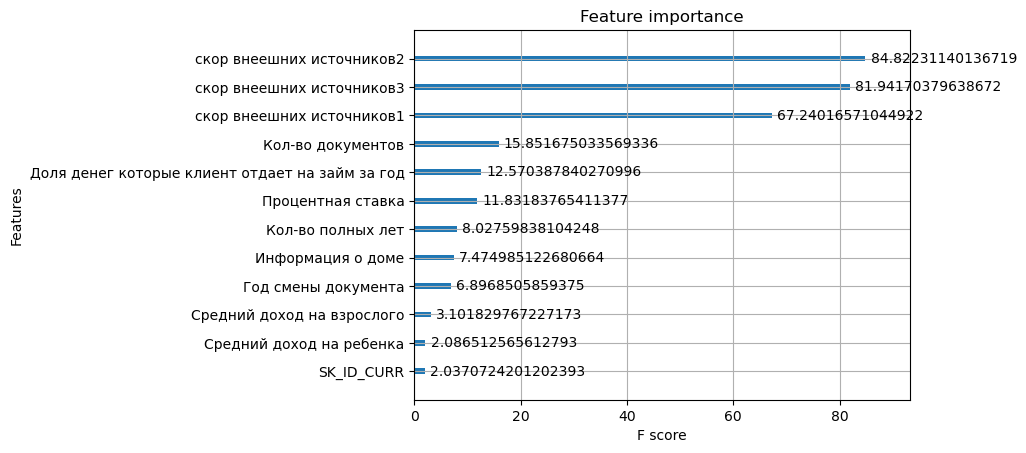

In [109]:
xgb.plot_importance(xgb_clf, importance_type='gain');

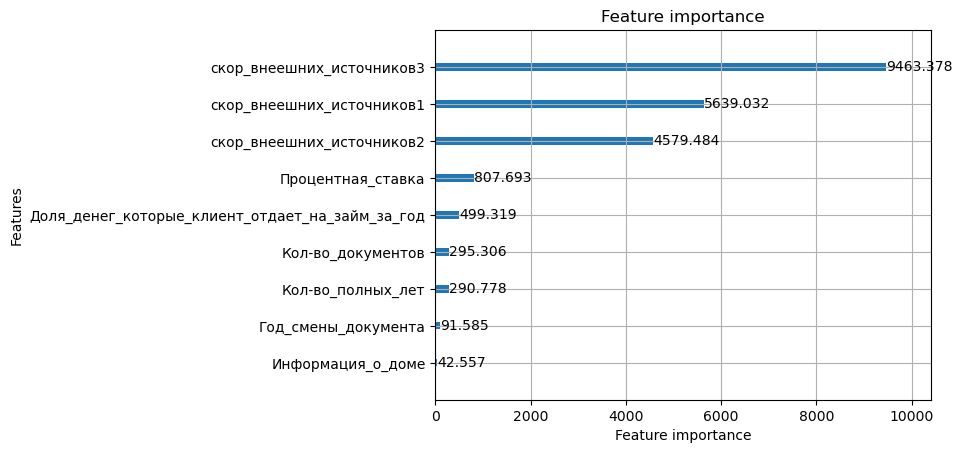

In [110]:
lgbm.plot_importance(lgbm_clf, importance_type='gain');

In [111]:
import shap

In [112]:
shap.initjs()

model_type='lgbm'
 
explainer = shap.TreeExplainer(lgbm_clf)
shap_values = explainer.shap_values(X_test)
 
if model_type=='lgbm':
    shap_values = shap_values[1]

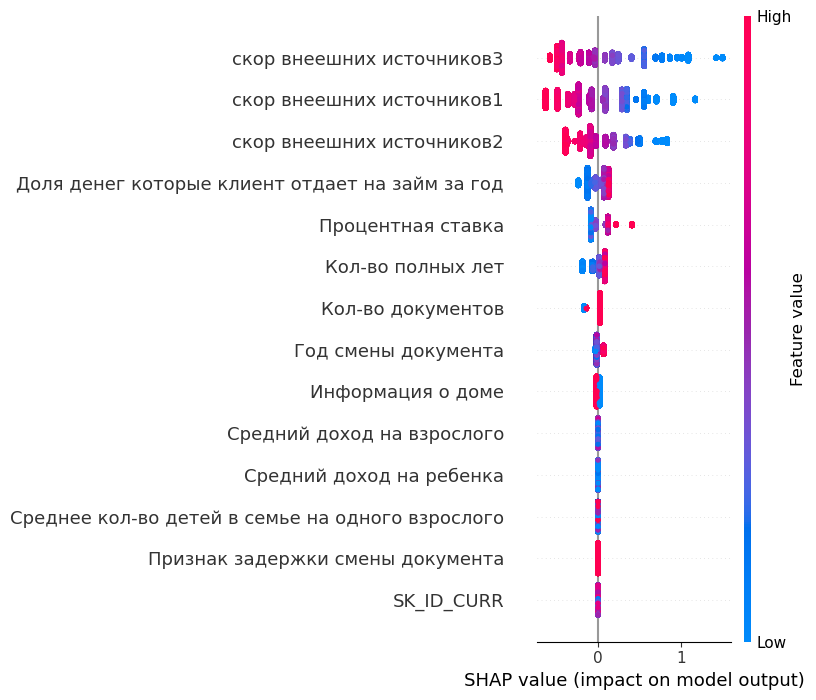

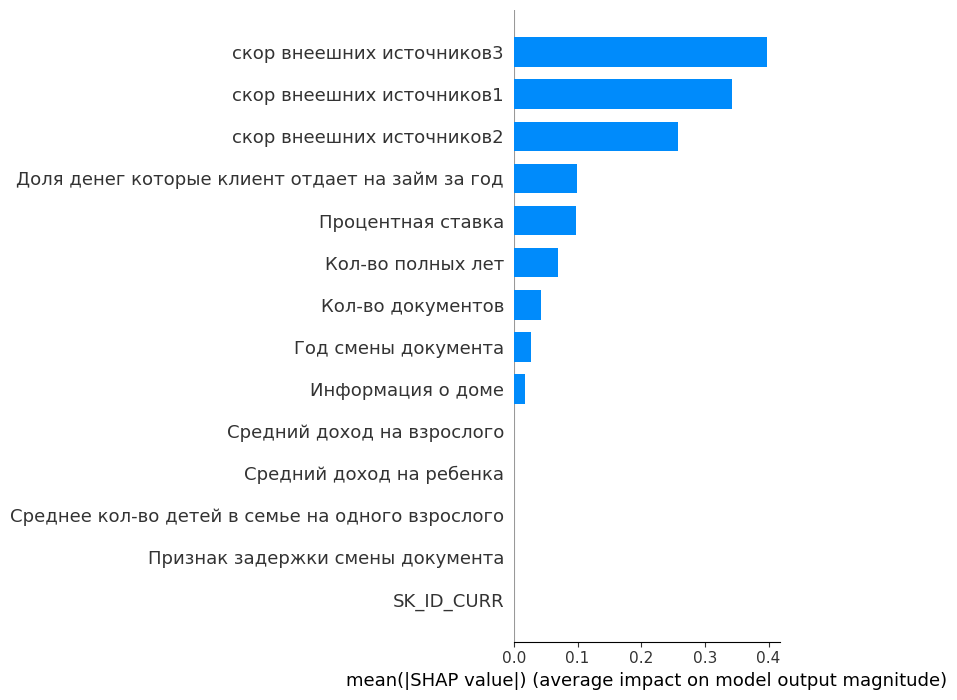

In [113]:
shap.summary_plot(shap_values, X_test, max_display=30)
 
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=30)